In [ ]:
import pandas as pd
import re
import string
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from collections import Counter
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import seaborn as sns

**Preprocessing**

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/Suicide_Detection.csv'
data = pd.read_csv(file_path)

print(data.head())

# remove null values
data.dropna(inplace=True)

# remove duplicates
data.drop_duplicates(inplace=True)

# remove URLs
data['text'] = data['text'].apply(lambda x: re.sub(r'http\S+|www\S+|https\S+', '', x, flags=re.MULTILINE))

# remove punctuations
data['text'] = data['text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# lowercasing
data['text'] = data['text'].str.lower()

# remove numbers
data['text'] = data['text'].apply(lambda x: re.sub(r'\d+', '', x))

# Tokenization
data['tokens'] = data['text'].apply(lambda x: x.split())

# Stop words removal
stop_words = set(stopwords.words('english'))
data['tokens'] = data['tokens'].apply(lambda x: [word for word in x if word not in stop_words])

# Stemming
stemmer = PorterStemmer()
data['tokens'] = data['tokens'].apply(lambda x: [stemmer.stem(word) for word in x])

# Lemmatization
lemmatizer = WordNetLemmatizer()
data['tokens'] = data['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

# Padding
max_len = 200
data['padded_tokens'] = pad_sequences(data['tokens'], maxlen=max_len, padding='post', truncating='post', dtype='object').tolist()

# Join tokens back to text
data['cleaned_text'] = data['tokens'].apply(lambda x: ' '.join(x))
print(data.head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Mounted at /content/drive
   Unnamed: 0                                               text        class
0           2  Ex Wife Threatening SuicideRecently I left my ...      suicide
1           3  Am I weird I don't get affected by compliments...  non-suicide
2           4  Finally 2020 is almost over... So I can never ...  non-suicide
3           8          i need helpjust help me im crying so hard      suicide
4           9  I’m so lostHello, my name is Adam (16) and I’v...      suicide
   Unnamed: 0                                               text        class  \
0           2  ex wife threatening suiciderecently i left my ...      suicide   
1           3  am i weird i dont get affected by compliments ...  non-suicide   
2           4  finally  is almost over so i can never hear  h...  non-suicide   
3           8          i need helpjust help me im crying so hard      suicide   
4           9  i’m so losthello my name is adam  and i’ve bee...      suicide   

                   

**Data Analysis**

shape: (232074, 6)


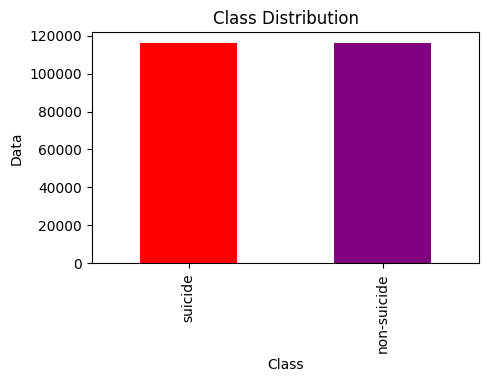

class
suicide        116037
non-suicide    116037
Name: count, dtype: int64


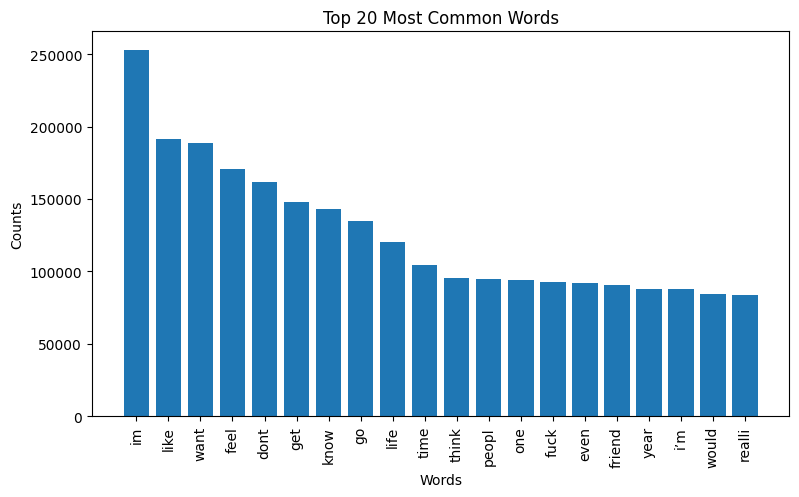

In [ ]:
print("shape:", data.shape)

plt.figure(figsize=(5, 3))
data['class'].value_counts().plot(kind='bar', color=['red', 'purple'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Data')
plt.show()
print(data['class'].value_counts())

all_words = ' '.join([text for text in data['cleaned_text']])
all_words = all_words.split()
word_freq = Counter(all_words)

most_common_words = word_freq.most_common(20)
words, counts = zip(*most_common_words)

plt.figure(figsize=(9, 5))
plt.bar(words, counts)
plt.title('Top 20 Most Common Words')
plt.xlabel('Words')
plt.ylabel('Counts')
plt.xticks(rotation=90)
plt.show()

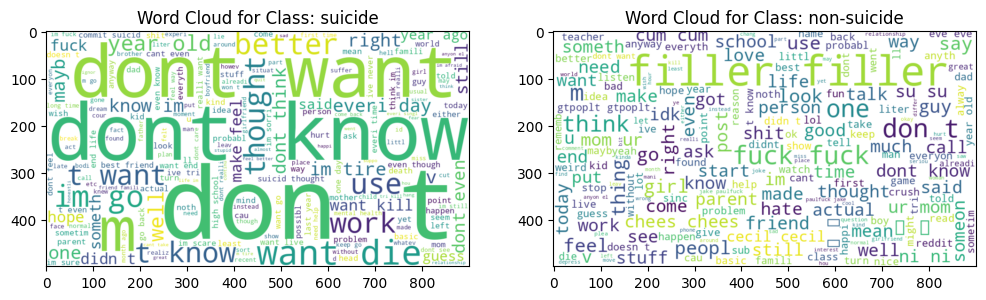

In [ ]:
from wordcloud import WordCloud
plt.figure(figsize=(12, 8))
subplot_index = 1
for cls in data['class'].unique():
    wordcloud = WordCloud(background_color='white', width=900, height=500).generate(' '.join(data[data['class'] == cls]['cleaned_text']))
    plt.subplot(1, len(data['class'].unique()), subplot_index)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Word Cloud for Class: ' + cls)
    subplot_index += 1
plt.show()

**Function to train and evaluate classifiers**

In [ ]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Accuracy: {acc}")
    print(f"Precision: {prec}")
    print(f"Recall: {rec}")
    print(f"F1 Score: {f1}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC Curve
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# List of classifiers
classifiers = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=50, max_depth=10)
}

**Feature Selection**

In [ ]:
tan = data.sample(frac = 0.02)
tan

,Unnamed: 0,text,class,tokens,padded_tokens,cleaned_text
85047,127738,im mad context i only have an xbox no computer...,non-suicide,"[im, mad, context, xbox, comput, use, monitor,...","[im, mad, context, xbox, comput, use, monitor,...",im mad context xbox comput use monitor doesnt ...
59368,89048,some last wordsthings were looking decent actu...,suicide,"[last, wordsth, look, decent, actual, midtwent...","[last, wordsth, look, decent, actual, midtwent...",last wordsth look decent actual midtwenti star...
185160,277919,i don’t even know how my friends dont know im ...,non-suicide,"[don’t, even, know, friend, dont, know, im, bi...","[don’t, even, know, friend, dont, know, im, bi...",don’t even know friend dont know im bi yet bru...
213188,319693,i just had to watch my dog die i dont know how...,non-suicide,"[watch, dog, die, dont, know, feel, fell, angr...","[watch, dog, die, dont, know, feel, fell, angr...",watch dog die dont know feel fell angri also r...
223109,334585,best shows to watch when suicidallooking for s...,suicide,"[best, show, watch, suicidallook, someth, bing...","[best, show, watch, suicidallook, someth, bing...",best show watch suicidallook someth bing watch...
...,...,...,...,...,...,...
182888,274474,im here to out sub the way cause i can,non-suicide,"[im, sub, way, caus]","[im, sub, way, caus, 0.0, 0.0, 0.0, 0.0, 0.0, ...",im sub way caus
145899,218958,i hate thisi didn’t ask to be molested\n\ni di...,suicide,"[hate, thisi, didn’t, ask, molest, didn’t, ask...","[hate, thisi, didn’t, ask, molest, didn’t, ask...",hate thisi didn’t ask molest didn’t ask diagno...
17090,25758,i dont have anything to say im just tiredim ph...,suicide,"[dont, anyth, say, im, tiredim, physic, emot, ...","[dont, anyth, say, im, tiredim, physic, emot, ...",dont anyth say im tiredim physic emot exhaust ...
63986,95939,i f cant stop thinking about my ex and ive bee...,suicide,"[f, cant, stop, think, ex, ive, want, attempt,...","[f, cant, stop, think, ex, ive, want, attempt,...",f cant stop think ex ive want attempt whileim ...


## TF-IDF

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(tan['cleaned_text'])
y = tan['class'].apply(lambda x: 1 if x == 'suicide' else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train distribution:\n", y_train.value_counts())
print("y_test distribution:\n", y_test.value_counts())

feature_names = tfidf_vectorizer.get_feature_names_out()
print("Feature names:", feature_names[:50])

print("Sample feature vector:")
print(X[0])

X_train shape: (3712, 14127)
X_test shape: (929, 14127)
y_train distribution:
 class
1    1881
0    1831
Name: count, dtype: int64
y_test distribution:
 class
1    469
0    460
Name: count, dtype: int64
Feature names: ['aaaa' 'aaaaa' 'aaaaaa' 'aaaaaaa' 'aaaaaaaa' 'aaaaaaaaaaaa'
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaah'
 'aaaaaaaaaaaaaahhhh' 'aaaaaaaaaaarrrrrrrrrrrggggggggg' 'aaaaaaaahh'
 'aaaaaand' 'aaaand' 'aaand' 'aah' 'aaladeen' 'aamp' 'aask' 'aayi' 'ab'
 'aback' 'abandon' 'abandondelet' 'abandoned' 'abba' 'abbi' 'abd' 'abe'
 'abhor' 'abhorr' 'abid' 'abil' 'abilifi' 'abit' 'abl' 'ableism' 'ableist'
 'abnorm' 'abolish' 'abolut' 'abomin' 'abort' 'aboslut' 'abou' 'abouttw'
 'abovepar' 'abraham' 'abras' 'abroad' 'abrupt' 'absenc']
Sample feature vector:
  (0, 7020)	0.1861354307433993
  (0, 3944)	0.3773543532476409
  (0, 1104)	0.3537640467512395
  (0, 7203)	0.267

**Classifiers:**

Naive Bayes:
Accuracy: 0.8223896663078579
Precision: 0.7428115015974441
Recall: 0.9914712153518124
F1 Score: 0.8493150684931507


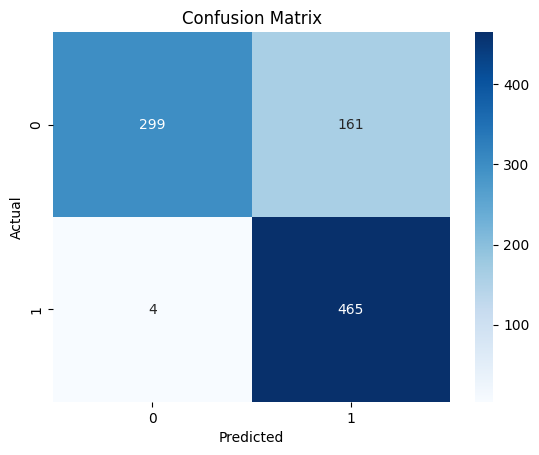

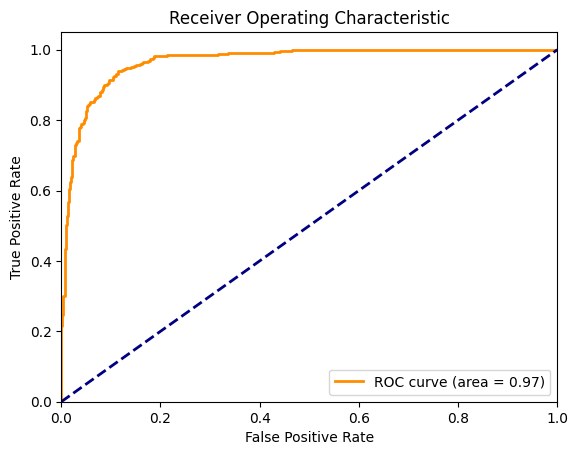

Logistic Regression:
Accuracy: 0.9009687836383208
Precision: 0.917960088691796
Recall: 0.8827292110874201
F1 Score: 0.9000000000000001


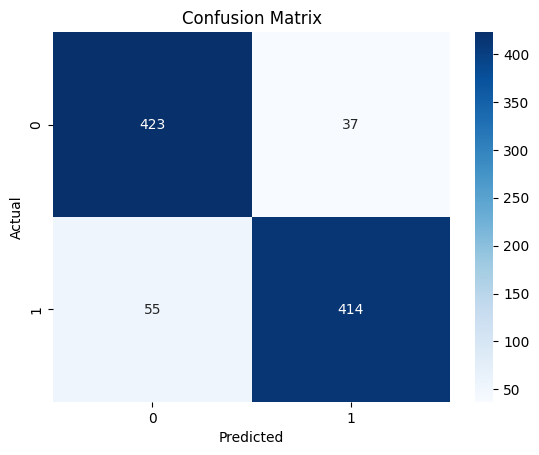

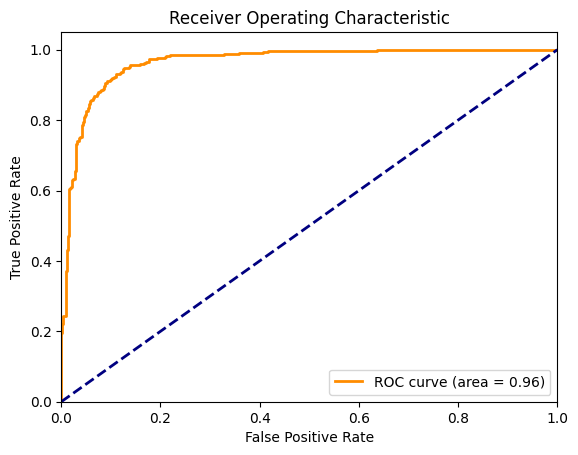

Random Forest:
Accuracy: 0.8503767491926802
Precision: 0.9024390243902439
Recall: 0.7889125799573561
F1 Score: 0.8418657565415245


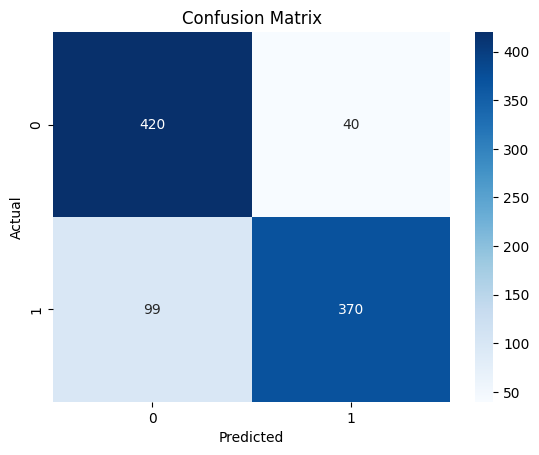

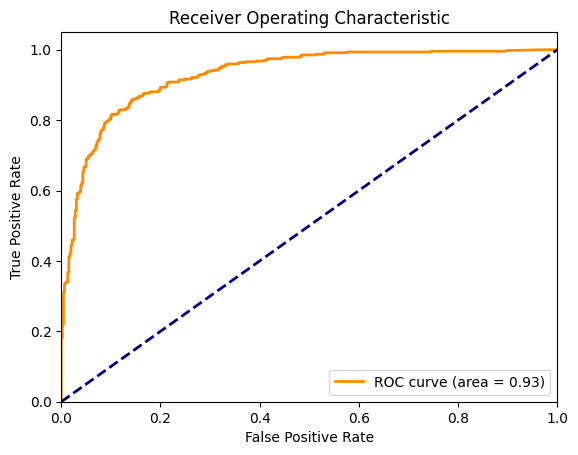

In [ ]:
for name, clf in classifiers.items():
    print(f"{name}:")
    evaluate_model(clf, X_train, y_train, X_test, y_test)

Support Vector Machine:
Accuracy: 0.9149623250807319
Precision: 0.9184549356223176
Recall: 0.9125799573560768
F1 Score: 0.9155080213903745


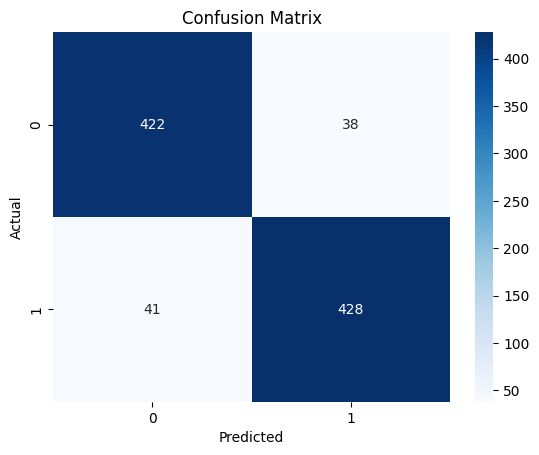

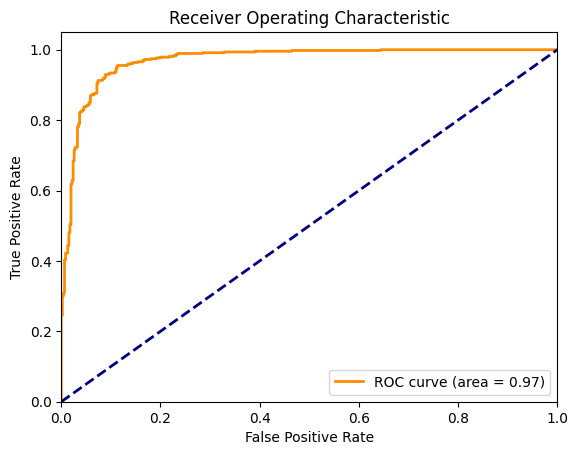

In [ ]:
print("Support Vector Machine:")
svm = SVC(kernel='linear', probability=True)
evaluate_model(svm, X_train, y_train, X_test, y_test)

K-Nearest Neighbors:
Accuracy: 0.7944025834230355
Precision: 0.9263803680981595
Recall: 0.6439232409381663
F1 Score: 0.7597484276729559


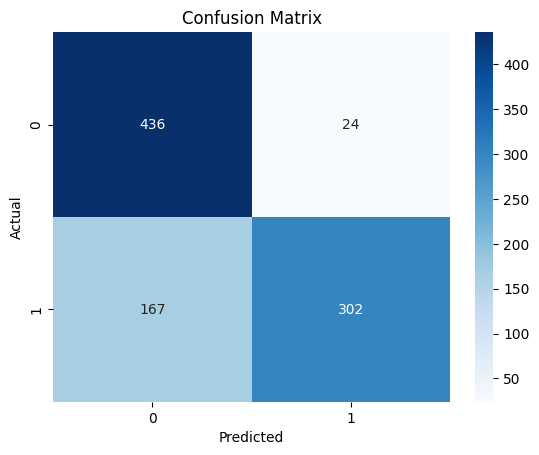

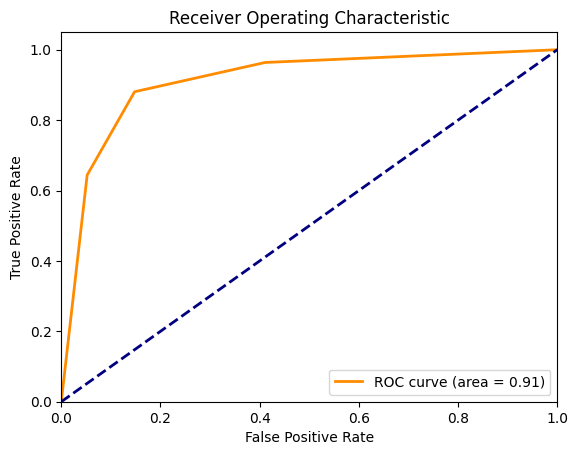

In [ ]:
print("K-Nearest Neighbors:")
knn = KNeighborsClassifier(n_neighbors=5, algorithm='brute')
evaluate_model(knn, X_train, y_train, X_test, y_test)

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=3000)
X = tfidf_vectorizer.fit_transform(data['cleaned_text'])
y = data['class'].apply(lambda x: 1 if x == 'suicide' else 0)

selector = SelectKBest(chi2, k=1000)
X_new = selector.fit_transform(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train distribution:\n", y_train.value_counts())
print("y_test distribution:\n", y_test.value_counts())

print("X shape:", X.shape)

X_train shape: (185659, 1000)
X_test shape: (46415, 1000)
y_train distribution:
 class
1    92909
0    92750
Name: count, dtype: int64
y_test distribution:
 class
0    23287
1    23128
Name: count, dtype: int64
X shape: (232074, 3000)


In [ ]:
feature_names = tfidf_vectorizer.get_feature_names_out()
print("Feature names:", feature_names[:50])

print("Sample feature vector:")
print(X_new[0])

Feature names: ['abandon' 'abil' 'abl' 'abort' 'abroad' 'absolut' 'abt' 'abus' 'academ'
 'accept' 'access' 'accid' 'accident' 'accomplish' 'accord' 'account'
 'accus' 'ach' 'achiev' 'acknowledg' 'acn' 'acquaint' 'across' 'act'
 'action' 'activ' 'actual' 'ad' 'add' 'addict' 'addit' 'address' 'adhd'
 'admit' 'adopt' 'ador' 'adult' 'advanc' 'advantag' 'adventur' 'advic'
 'advis' 'af' 'affair' 'affect' 'afford' 'afraid' 'afterlif' 'afternoon'
 'afterward']
Sample feature vector:
  (0, 255)	0.09213064001267592
  (0, 433)	0.08601795370565933
  (0, 542)	0.11012105783644932
  (0, 971)	0.11038995810961705
  (0, 454)	0.05048882703863652
  (0, 331)	0.054417982359279395
  (0, 176)	0.11229436606519289
  (0, 216)	0.10388600413507568
  (0, 133)	0.12181712345946863
  (0, 528)	0.07577625502536375
  (0, 808)	0.07684310538241602
  (0, 218)	0.10070957450322797
  (0, 393)	0.12196146291885675
  (0, 828)	0.11367794564337665
  (0, 711)	0.064506520189009
  (0, 395)	0.1710389035207807
  (0, 950)	0.0730987752222

Naive Bayes:
Accuracy: 0.8613594743078746
Precision: 0.8057886059717897
Recall: 0.9509685230024213
F1 Score: 0.8723796680086469


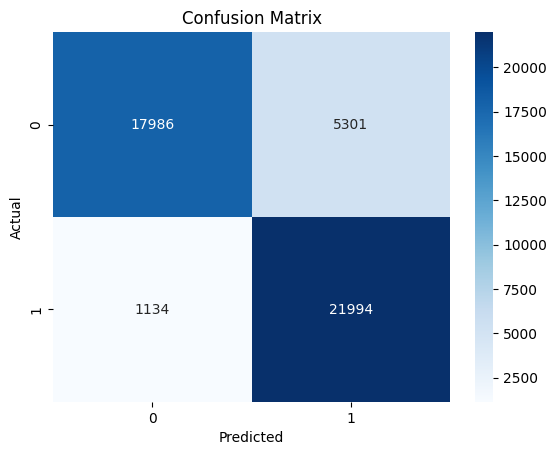

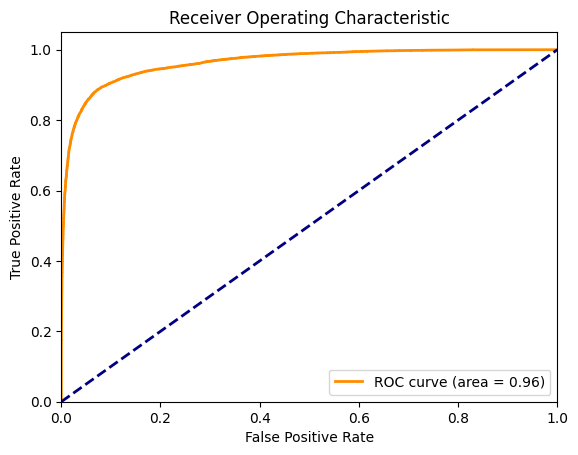

Logistic Regression:
Accuracy: 0.9262307443714316
Precision: 0.935890629147863
Recall: 0.9146056727775856
F1 Score: 0.9251257380275529


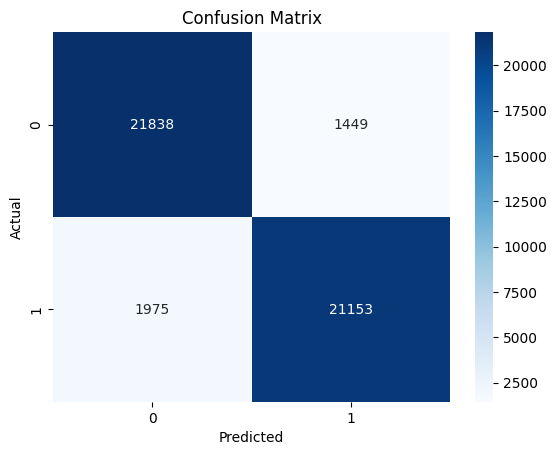

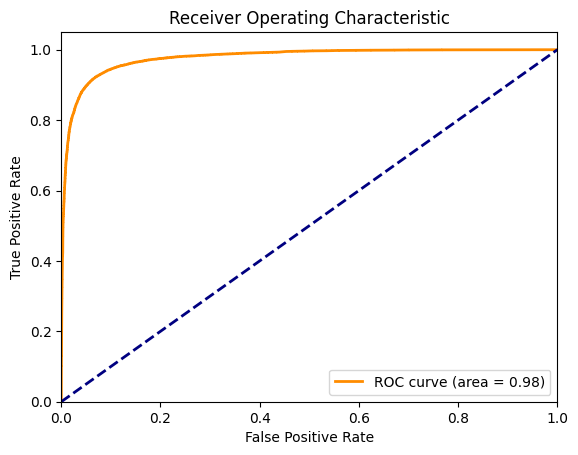

Random Forest:
Accuracy: 0.8486696111170957
Precision: 0.8986533320130706
Recall: 0.7848062953995157
F1 Score: 0.8378802566588193


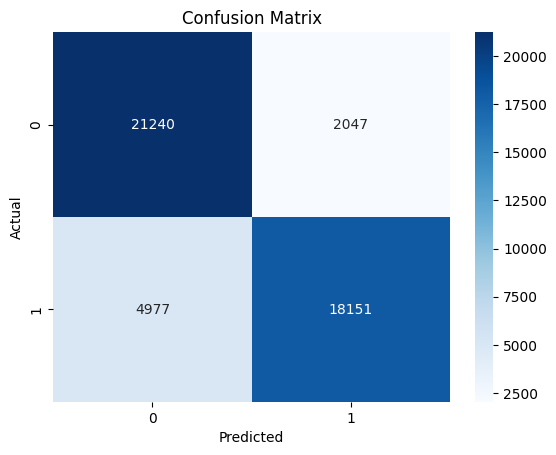

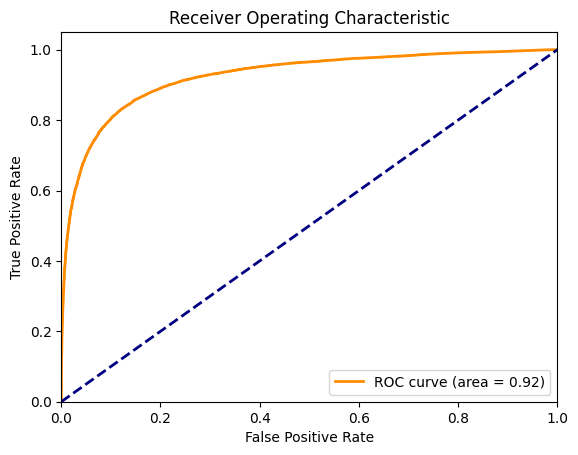

In [ ]:
for name, clf in classifiers.items():
    print(f"{name}:")
    evaluate_model(clf, X_train, y_train, X_test, y_test)

In [ ]:
# Support Vector Machine
#print("Support Vector Machine:")
#svm = SVC(kernel='linear', probability=True)
#evaluate_model(svm, X_train, y_train, X_test, y_test)

Using a smaller subset for testing

Support Vector Machine:
Accuracy: 0.9211433496121804
Precision: 0.9308288610614192
Recall: 0.907822041291073
F1 Score: 0.9191815103783306


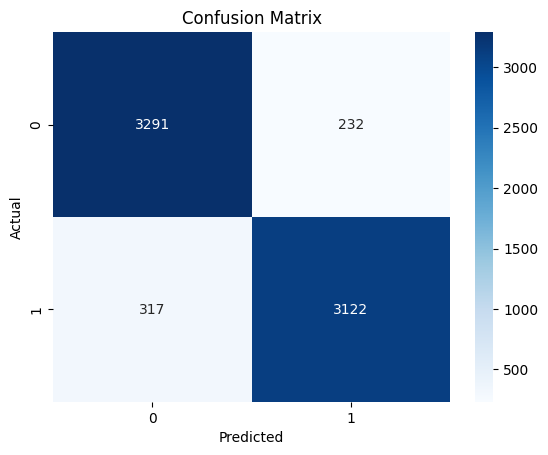

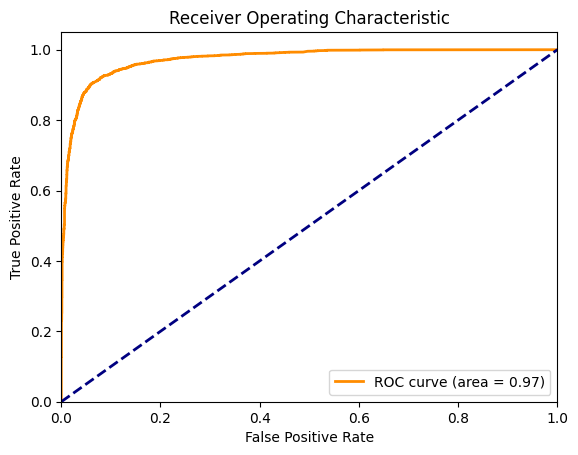

K-Nearest Neighbors:
Accuracy: 0.5293019247342717
Precision: 0.8894230769230769
Recall: 0.05379470776388485
F1 Score: 0.10145324924595558


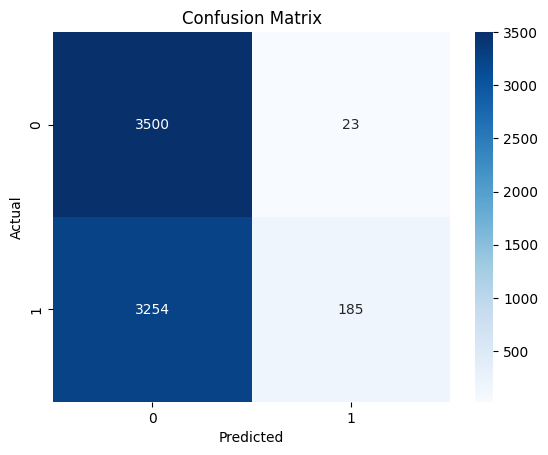

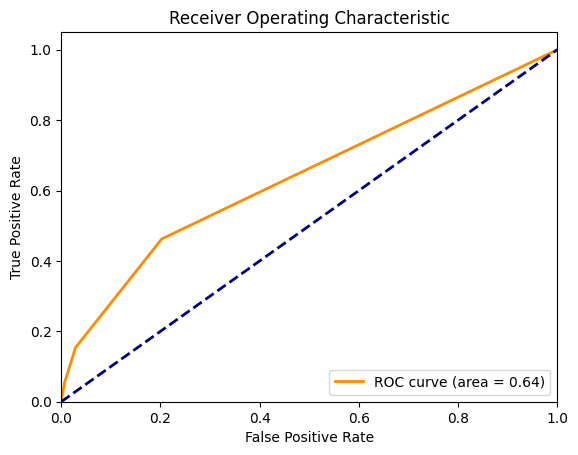

In [ ]:
X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, test_size=0.85, random_state=42)
X_test_sample, _, y_test_sample, _ = train_test_split(X_test, y_test, test_size=0.85, random_state=42)

print("Support Vector Machine:")
svm = SVC(kernel='linear', probability=True)
evaluate_model(svm, X_train_sample, y_train_sample, X_test_sample, y_test_sample)

print("K-Nearest Neighbors:")
knn = KNeighborsClassifier(n_neighbors=5, algorithm='brute')
evaluate_model(knn, X_train_sample, y_train_sample, X_test_sample, y_test_sample)

## Bag of words

In [ ]:
bow_vectorizer = CountVectorizer(max_features=5000)
X = bow_vectorizer.fit_transform(data['cleaned_text'])
y = data['class'].apply(lambda x: 1 if x == 'suicide' else 0)

selector = SelectKBest(chi2, k=1000)
X_new = selector.fit_transform(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

feature_names = bow_vectorizer.get_feature_names_out()
print("Feature names:", feature_names[:50])

print("Sample feature vector:")
print(X_new[0])

Feature names: ['aa' 'aaaaaaaaaaaaaaaaaaaaaaaaa' 'ab' 'abandon' 'abil' 'abl' 'abnorm'
 'abort' 'abroad' 'absenc' 'absent' 'absolut' 'absorb' 'absurd' 'abt'
 'abus' 'abyss' 'ac' 'academ' 'academi' 'acc' 'accent' 'accept' 'access'
 'accid' 'accident' 'accommod' 'accompani' 'accomplish' 'accord' 'account'
 'accumul' 'accur' 'accus' 'ace' 'ach' 'achiev' 'acid' 'acknowledg' 'acn'
 'acquaint' 'acquir' 'across' 'act' 'action' 'activ' 'actor' 'actual'
 'acut' 'ad']
Sample feature vector:
  (0, 304)	1
  (0, 967)	3
  (0, 882)	3
  (0, 507)	1
  (0, 383)	1
  (0, 143)	2
  (0, 918)	1
  (0, 511)	1
  (0, 585)	2
  (0, 216)	1
  (0, 713)	1
  (0, 378)	1
  (0, 67)	2
  (0, 208)	3
  (0, 21)	1
  (0, 79)	1
  (0, 848)	1
  (0, 822)	1
  (0, 861)	1
  (0, 487)	1
  (0, 949)	1
  (0, 83)	1
  (0, 454)	1
  (0, 159)	1
  (0, 495)	1
  (0, 535)	1
  (0, 644)	1
  (0, 622)	1
  (0, 374)	2
  (0, 954)	1
  (0, 402)	2
  (0, 708)	1
  (0, 852)	1
  (0, 400)	1
  (0, 212)	1
  (0, 399)	1
  (0, 830)	1
  (0, 536)	1
  (0, 130)	1
  (0, 210)	1

**Classifiers:**

Naive Bayes:
Accuracy: 0.8412582139394592
Precision: 0.7817304254558456
Recall: 0.9453908682116915
F1 Score: 0.8558064894907824


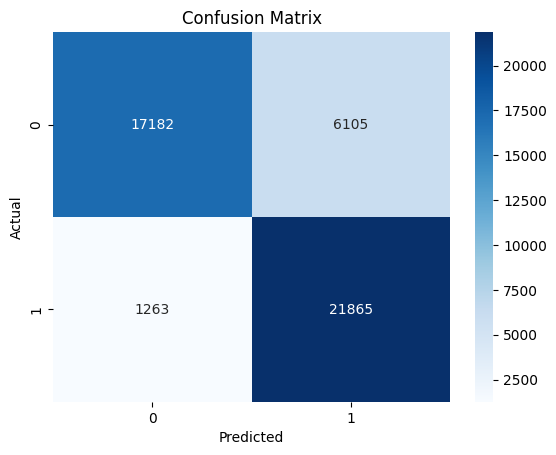

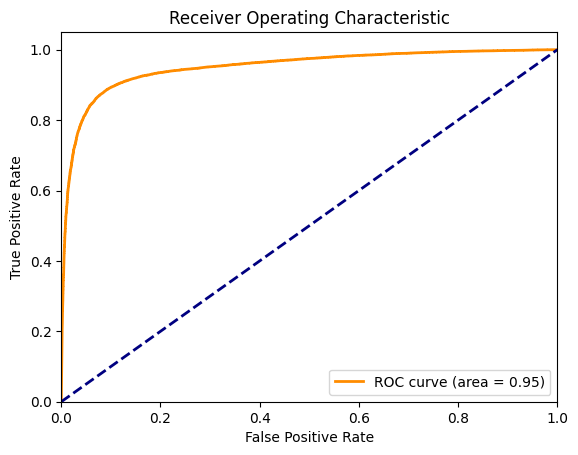

Logistic Regression:
Accuracy: 0.9078099752235269
Precision: 0.9421949045183691
Recall: 0.8682549290902801
F1 Score: 0.9037150379154384


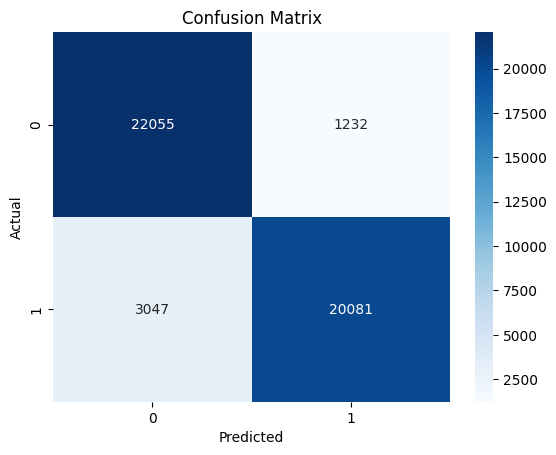

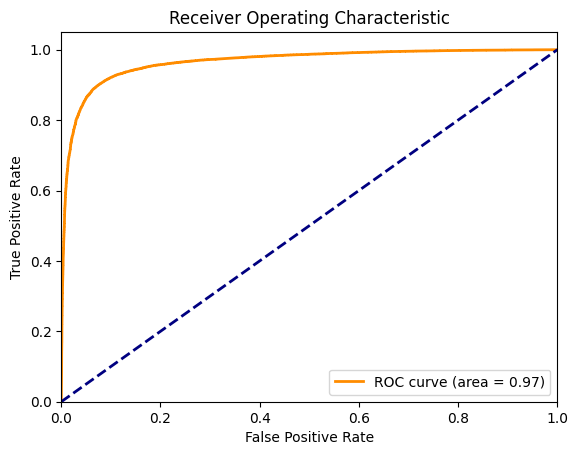

Random Forest:
Accuracy: 0.8514488850587094
Precision: 0.8946370399183158
Recall: 0.7955724662746455
F1 Score: 0.8422016248998743


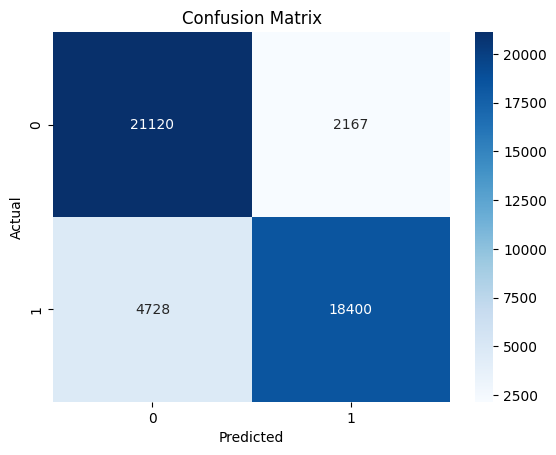

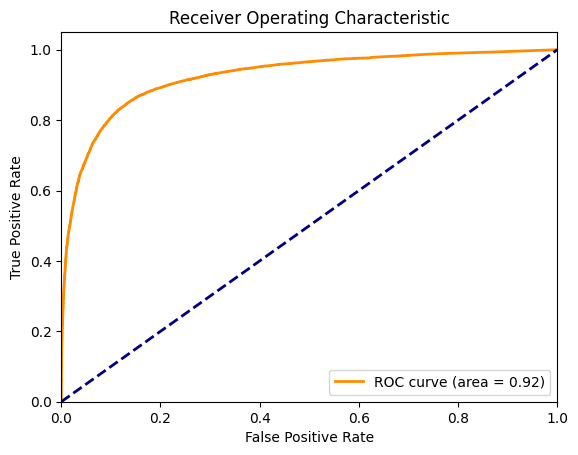

In [ ]:
for name, clf in classifiers.items():
    print(f"{name}:")
    evaluate_model(clf, X_train, y_train, X_test, y_test)

Support Vector Machine:
Accuracy: 0.900316001149095
Precision: 0.9290403251015943
Recall: 0.8642047106717069
F1 Score: 0.895450436878578


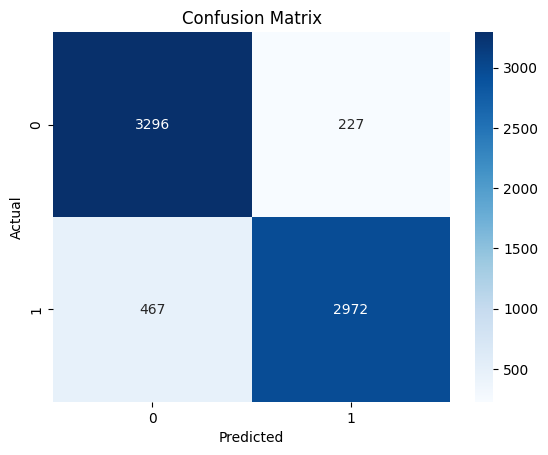

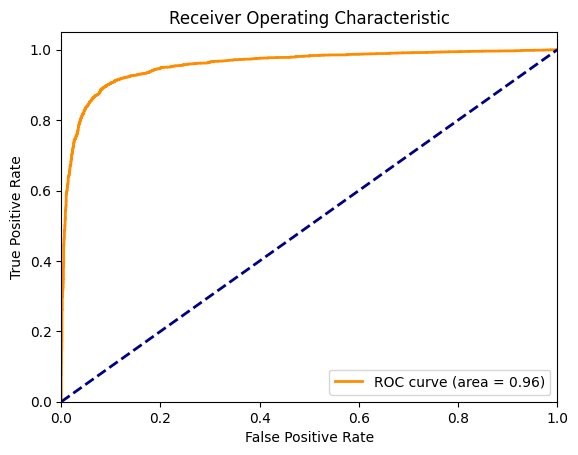

K-Nearest Neighbors:
Accuracy: 0.7459063487503591
Precision: 0.9191767068273092
Recall: 0.5324222157603955
F1 Score: 0.6742772969987112


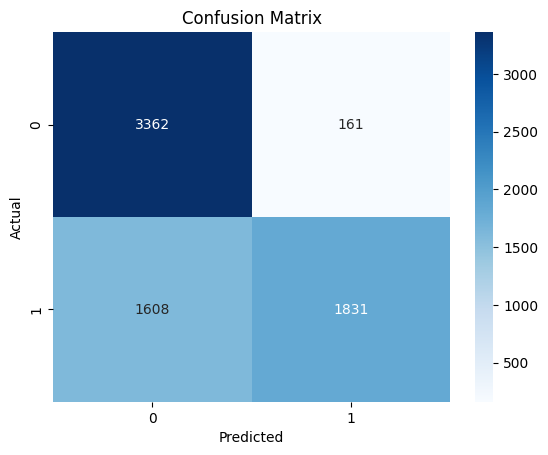

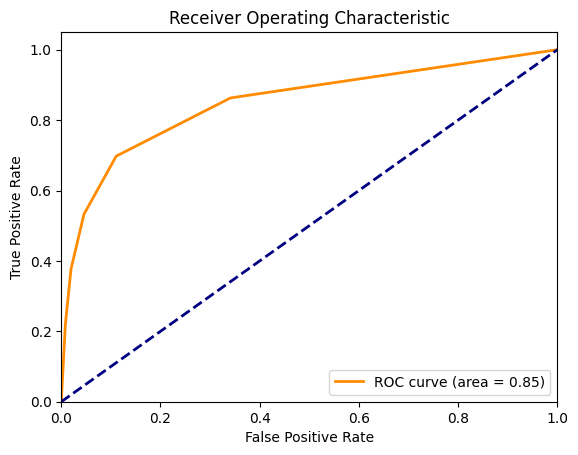

In [ ]:
X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, test_size=0.85, random_state=42)
X_test_sample, _, y_test_sample, _ = train_test_split(X_test, y_test, test_size=0.85, random_state=42)

print("Support Vector Machine:")
svm = SVC(kernel='linear', probability=True)
evaluate_model(svm, X_train_sample, y_train_sample, X_test_sample, y_test_sample)

print("K-Nearest Neighbors:")
knn = KNeighborsClassifier(n_neighbors=5, algorithm='brute')
evaluate_model(knn, X_train_sample, y_train_sample, X_test_sample, y_test_sample)

## Unigram

In [ ]:
ngram_vectorizer = CountVectorizer(max_features=5000, ngram_range=(1, 1))
X = ngram_vectorizer.fit_transform(data['cleaned_text'])
y = data['class'].apply(lambda x: 1 if x == 'suicide' else 0)

selector = SelectKBest(chi2, k=1000)
X_new = selector.fit_transform(X, y)

print("Shape of X_new:", X_new.shape)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

feature_names = ngram_vectorizer.get_feature_names_out()
print("Feature names:", feature_names[:50])

print("Sample feature vector:")
print(X_new[0])

Shape of X_new: (232074, 1000)
Feature names: ['aa' 'aaaaaaaaaaaaaaaaaaaaaaaaa' 'ab' 'abandon' 'abil' 'abl' 'abnorm'
 'abort' 'abroad' 'absenc' 'absent' 'absolut' 'absorb' 'absurd' 'abt'
 'abus' 'abyss' 'ac' 'academ' 'academi' 'acc' 'accent' 'accept' 'access'
 'accid' 'accident' 'accommod' 'accompani' 'accomplish' 'accord' 'account'
 'accumul' 'accur' 'accus' 'ace' 'ach' 'achiev' 'acid' 'acknowledg' 'acn'
 'acquaint' 'acquir' 'across' 'act' 'action' 'activ' 'actor' 'actual'
 'acut' 'ad']
Sample feature vector:
  (0, 304)	1
  (0, 967)	3
  (0, 882)	3
  (0, 507)	1
  (0, 383)	1
  (0, 143)	2
  (0, 918)	1
  (0, 511)	1
  (0, 585)	2
  (0, 216)	1
  (0, 713)	1
  (0, 378)	1
  (0, 67)	2
  (0, 208)	3
  (0, 21)	1
  (0, 79)	1
  (0, 848)	1
  (0, 822)	1
  (0, 861)	1
  (0, 487)	1
  (0, 949)	1
  (0, 83)	1
  (0, 454)	1
  (0, 159)	1
  (0, 495)	1
  (0, 535)	1
  (0, 644)	1
  (0, 622)	1
  (0, 374)	2
  (0, 954)	1
  (0, 402)	2
  (0, 708)	1
  (0, 852)	1
  (0, 400)	1
  (0, 212)	1
  (0, 399)	1
  (0, 830)	1
  (0, 5

**Classifiers:**

Naive Bayes:
Accuracy: 0.8412582139394592
Precision: 0.7817304254558456
Recall: 0.9453908682116915
F1 Score: 0.8558064894907824


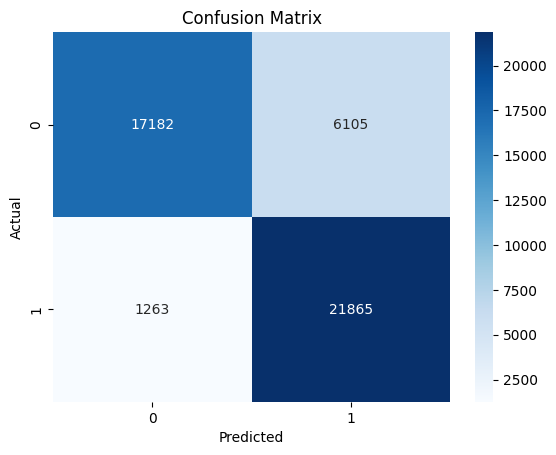

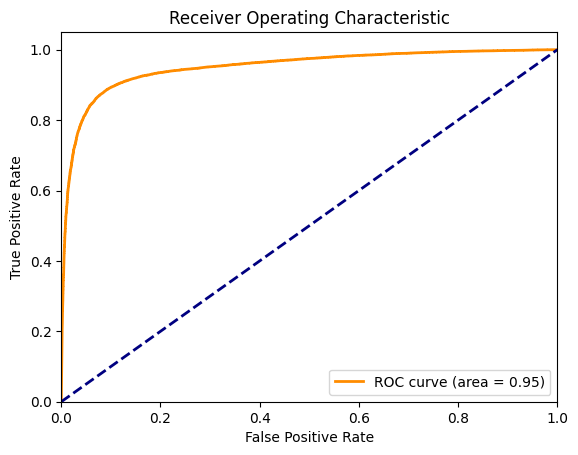

Logistic Regression:
Accuracy: 0.9078099752235269
Precision: 0.9421949045183691
Recall: 0.8682549290902801
F1 Score: 0.9037150379154384


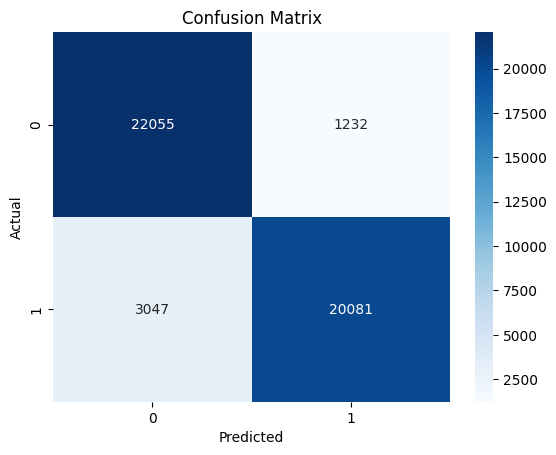

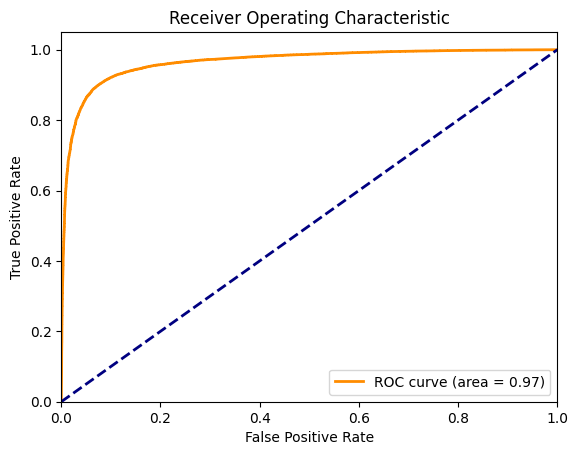

Random Forest:
Accuracy: 0.8498114833566734
Precision: 0.8901714561700073
Recall: 0.7969128329297821
F1 Score: 0.8409645700727761


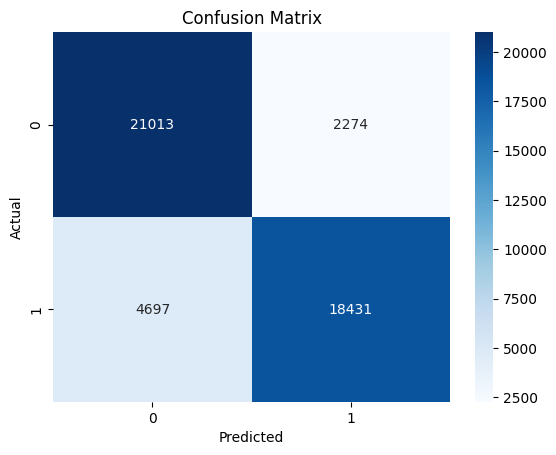

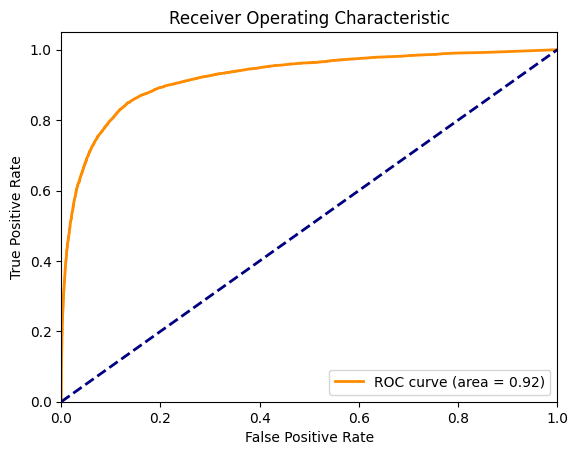

In [ ]:
for name, clf in classifiers.items():
    print(f"{name}:")
    evaluate_model(clf, X_train, y_train, X_test, y_test)

Support Vector Machine:
Accuracy: 0.900316001149095
Precision: 0.9290403251015943
Recall: 0.8642047106717069
F1 Score: 0.895450436878578


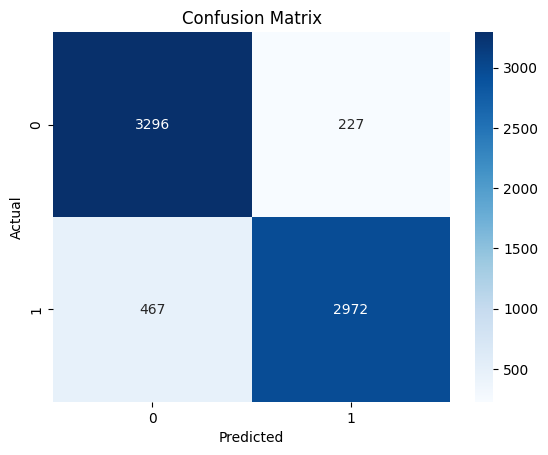

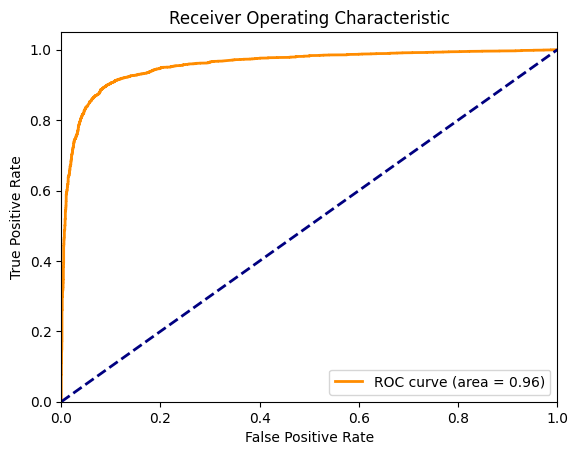

K-Nearest Neighbors:
Accuracy: 0.7459063487503591
Precision: 0.9191767068273092
Recall: 0.5324222157603955
F1 Score: 0.6742772969987112


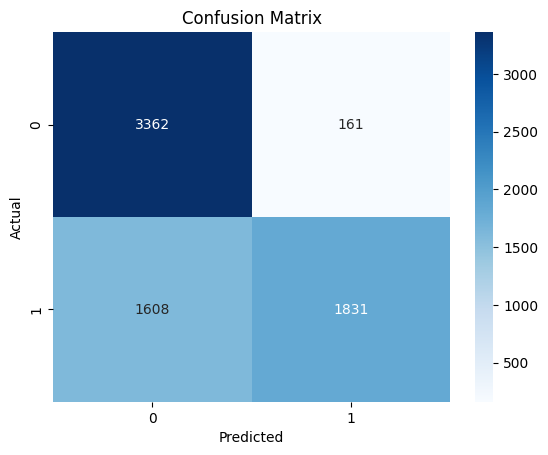

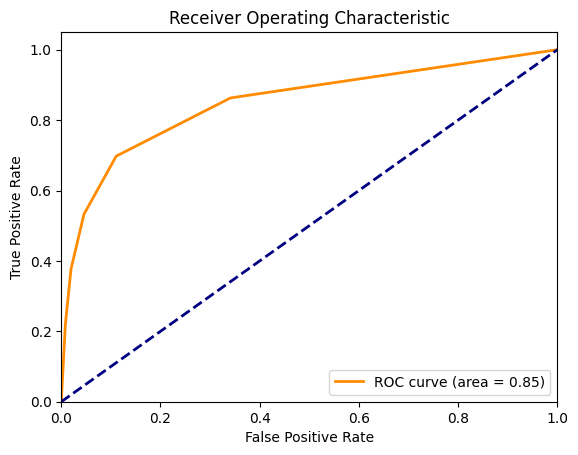

In [ ]:
X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, test_size=0.85, random_state=42)
X_test_sample, _, y_test_sample, _ = train_test_split(X_test, y_test, test_size=0.85, random_state=42)

print("Support Vector Machine:")
svm = SVC(kernel='linear', probability=True)
evaluate_model(svm, X_train_sample, y_train_sample, X_test_sample, y_test_sample)

print("K-Nearest Neighbors:")
knn = KNeighborsClassifier(n_neighbors=5, algorithm='brute')
evaluate_model(knn, X_train_sample, y_train_sample, X_test_sample, y_test_sample)

## Bigram

In [ ]:
ngram_vectorizer = CountVectorizer(max_features=5000, ngram_range=(2, 2))
X = ngram_vectorizer.fit_transform(data['cleaned_text'])
y = data['class'].apply(lambda x: 1 if x == 'suicide' else 0)

selector = SelectKBest(chi2, k=1000)
X_new = selector.fit_transform(X, y)

print("Shape of X_new:", X_new.shape)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

feature_names = ngram_vectorizer.get_feature_names_out()
print("Feature names:", feature_names[:50])

print("Sample feature vector:")
print(X_new[0])

Shape of X_new: (232074, 1000)
Feature names: ['abl afford' 'abl find' 'abl get' 'abl go' 'abl help' 'abl live'
 'abl make' 'abl see' 'abl take' 'abl talk' 'absolut hate' 'absolut noth'
 'absolut shit' 'abus parent' 'abus relationship' 'across countri'
 'act like' 'actual care' 'actual feel' 'actual fuck' 'actual get'
 'actual go' 'actual help' 'actual kill' 'actual like' 'actual make'
 'actual tri' 'actual want' 'adult life' 'advic would' 'afraid die'
 'afraid go' 'ago got' 'ago im' 'ago ive' 'ago start' 'ago still'
 'ago tri' 'aliv anymor' 'aliv dont' 'aliv im' 'almost everi'
 'almost everyth' 'almost kill' 'almost like' 'almost month' 'almost year'
 'alon cant' 'alon dont' 'alon feel']
Sample feature vector:
  (0, 293)	1
  (0, 104)	1
  (0, 85)	1
  (0, 413)	1


**Classifiers:**

Naive Bayes:
Accuracy: 0.5757836906172573
Precision: 0.5411165327210103
Recall: 0.9781649948114839
F1 Score: 0.696778366391524


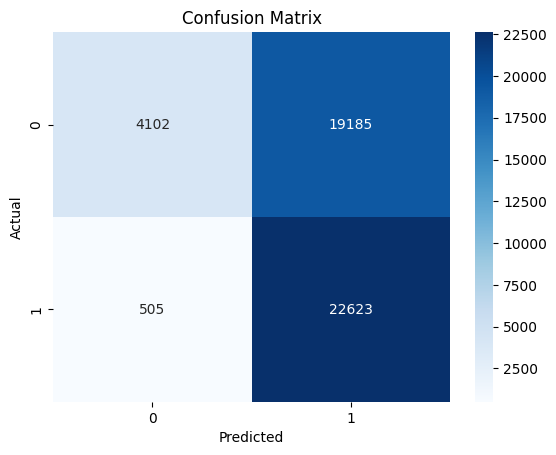

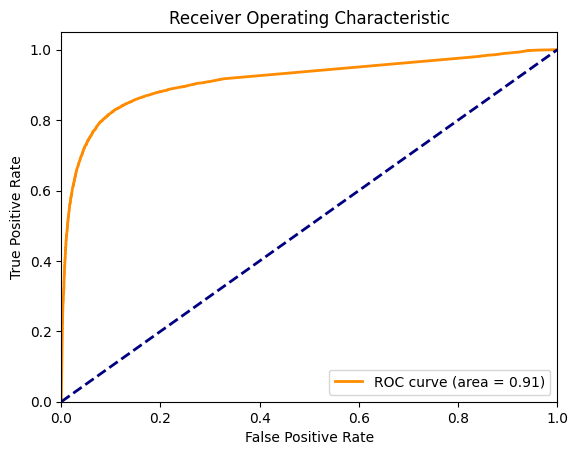

Logistic Regression:
Accuracy: 0.8635354949908435
Precision: 0.9272847547323427
Recall: 0.7879194050501557
F1 Score: 0.8519401589527817


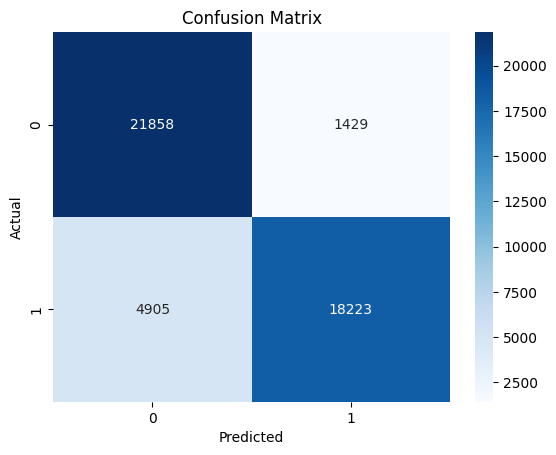

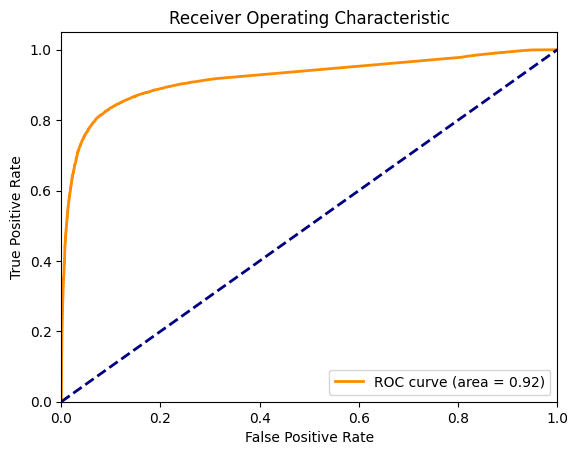

Random Forest:
Accuracy: 0.781428417537434
Precision: 0.8808001407872353
Recall: 0.6492130750605327
F1 Score: 0.7474797759800872


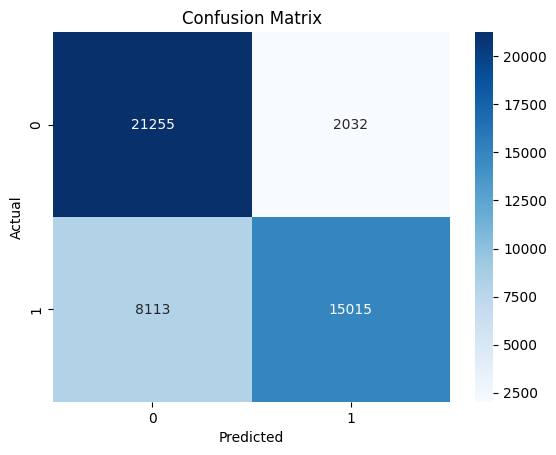

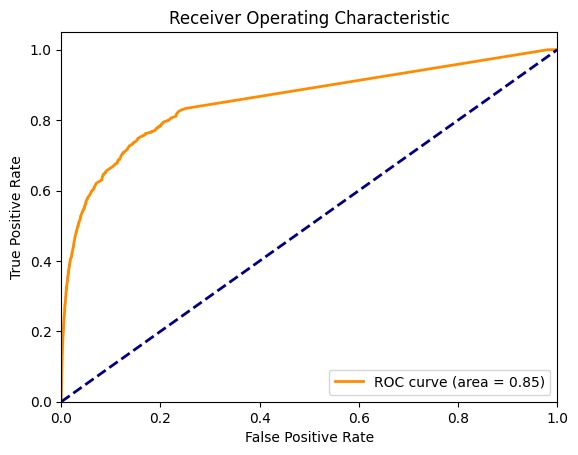

In [ ]:
for name, clf in classifiers.items():
    print(f"{name}:")
    evaluate_model(clf, X_train, y_train, X_test, y_test)

Support Vector Machine:
Accuracy: 0.8542085607584028
Precision: 0.9075319435104237
Recall: 0.7848211689444606
F1 Score: 0.8417277405270545


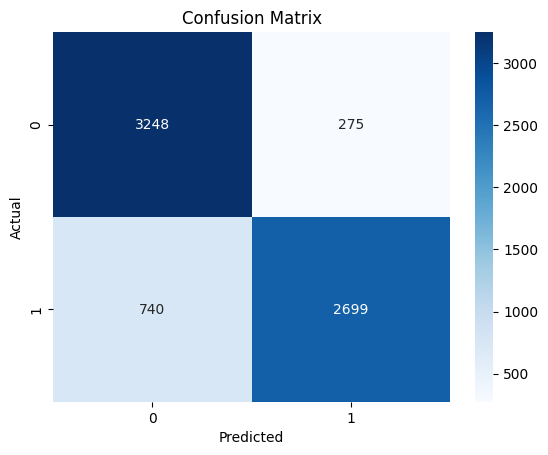

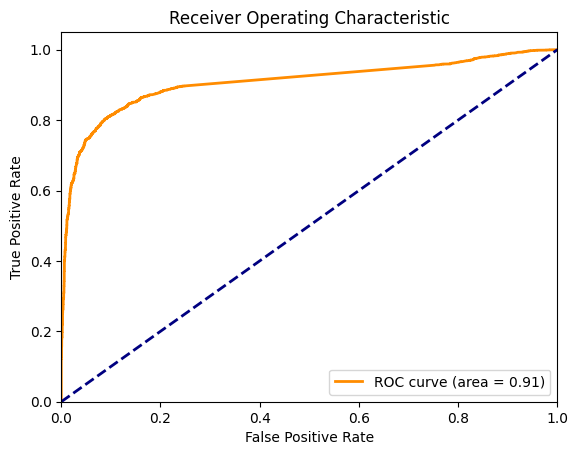

K-Nearest Neighbors:
Accuracy: 0.6539787417408791
Precision: 0.9029733959311425
Recall: 0.3355626635649898
F1 Score: 0.4892940428238287


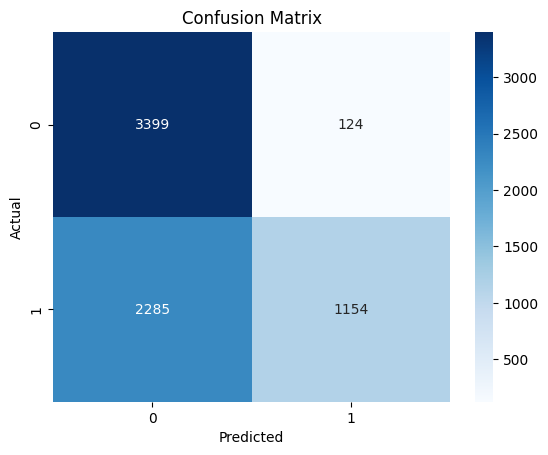

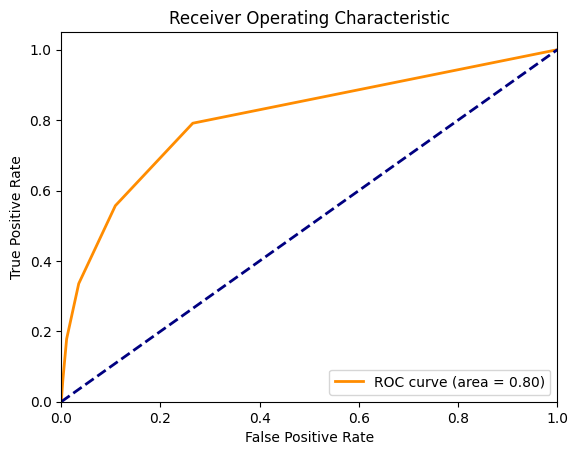

In [ ]:
X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, test_size=0.85, random_state=42)
X_test_sample, _, y_test_sample, _ = train_test_split(X_test, y_test, test_size=0.85, random_state=42)

print("Support Vector Machine:")
svm = SVC(kernel='linear', probability=True)
evaluate_model(svm, X_train_sample, y_train_sample, X_test_sample, y_test_sample)

print("K-Nearest Neighbors:")
knn = KNeighborsClassifier(n_neighbors=5, algorithm='brute')
evaluate_model(knn, X_train_sample, y_train_sample, X_test_sample, y_test_sample)

## Trigram

In [ ]:
ngram_vectorizer = CountVectorizer(max_features=5000, ngram_range=(3, 3))
X = ngram_vectorizer.fit_transform(data['cleaned_text'])
y = data['class'].apply(lambda x: 1 if x == 'suicide' else 0)

selector = SelectKBest(chi2, k=1000)
X_new = selector.fit_transform(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

print("Shape of X_new:", X_new.shape)

feature_names = ngram_vectorizer.get_feature_names_out()
print("Feature names:", feature_names[:50])

print("Sample feature vector:")
print(X_new[4])

Shape of X_new: (232074, 1000)
Feature names: ['aaaaaaaaaaaaaaaaaaaaaaaaa aaaaaaaaaaaaaaaaaaaaaaaaa aaaaaaaaaaaaaaaaaaaaaaaaa'
 'abl find job' 'abl get job' 'abl make friend' 'abl take care'
 'ach your shi' 'act like care' 'act like everyth' 'act like im'
 'act like noth' 'actual commit suicid' 'actual feel like'
 'actual give shit' 'actual want die' 'admit psych ward'
 'advic would appreci' 'afraid im go' 'againthi cannot repeartthi'
 'ago best friend' 'ago dont know' 'ago feel like' 'ago tri kill'
 'aliv dont want' 'aliv feel like' 'almost everi day' 'almost everi night'
 'almost everi singl' 'almost feel like' 'almost two year'
 'almost year ago' 'almost year old' 'almost year sinc' 'alon dont know'
 'alon dont want' 'alon even though' 'alon feel like' 'alon im tire'
 'alon rest life' 'alreadi feel like' 'alreadi tri kill' 'also don want'
 'also dont know' 'also dont want' 'also feel like' 'alway back mind'
 'alway come back' 'alway feel like' 'alway felt like' 'alway find way'
 'al

**Classifiers:**

Naive Bayes:
Accuracy: 0.5170742216955726
Precision: 0.5078460285670269
Recall: 0.9977084053960568
F1 Score: 0.6730839349522351


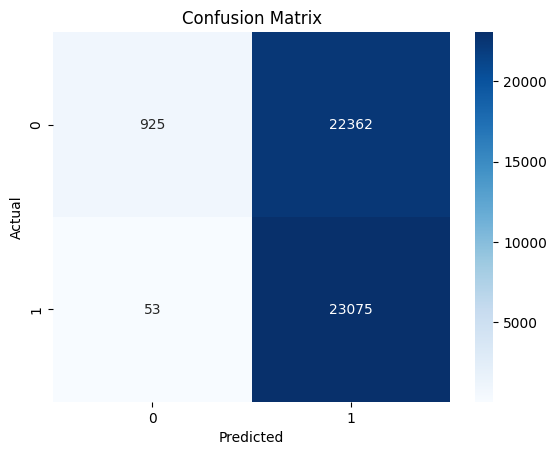

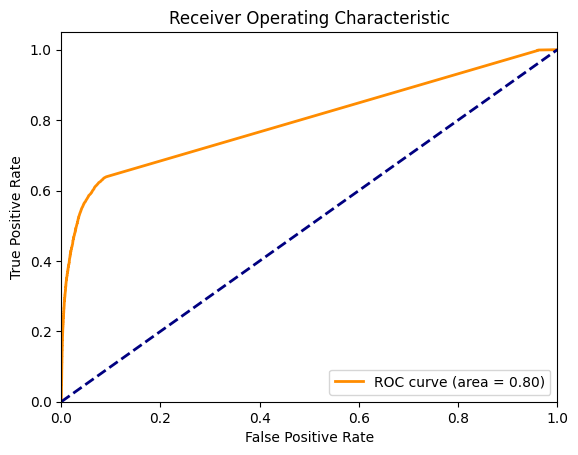

Logistic Regression:
Accuracy: 0.7715393730475062
Precision: 0.8993113123326106
Recall: 0.6097803528190937
F1 Score: 0.7267714506570471


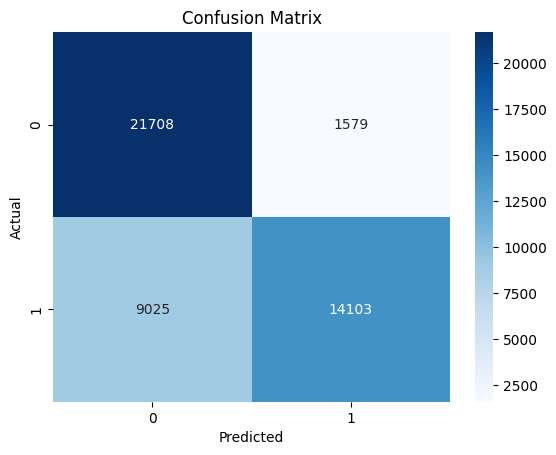

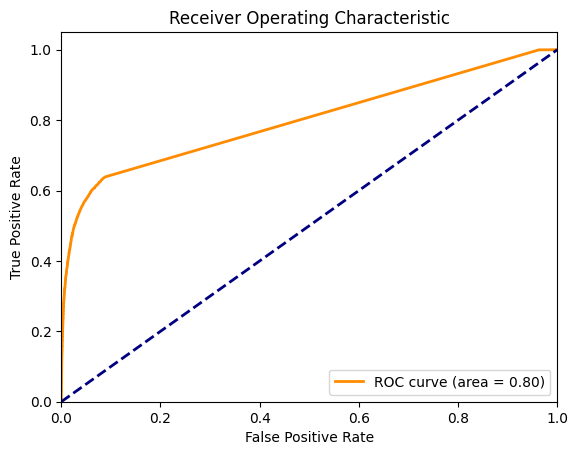

Random Forest:
Accuracy: 0.654422061833459
Precision: 0.9136321195144724
Recall: 0.33846419923901766
F1 Score: 0.49394245330641084


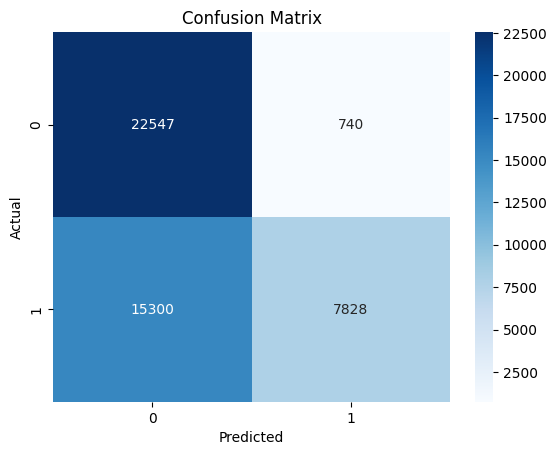

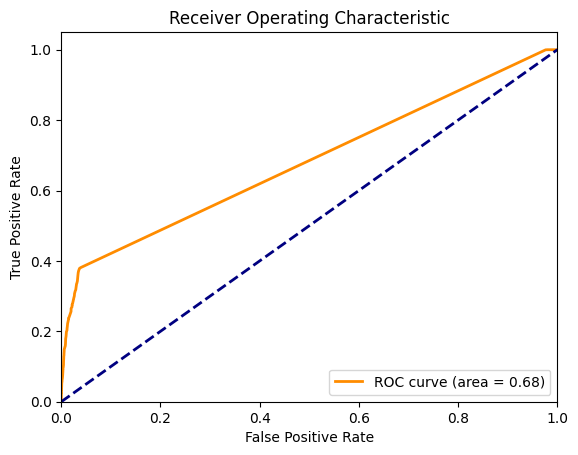

In [ ]:
for name, clf in classifiers.items():
    print(f"{name}:")
    evaluate_model(clf, X_train, y_train, X_test, y_test)

Support Vector Machine:
Accuracy: 0.7601264004596381
Precision: 0.9014979573309124
Recall: 0.5774934574004071
F1 Score: 0.7040056717476072


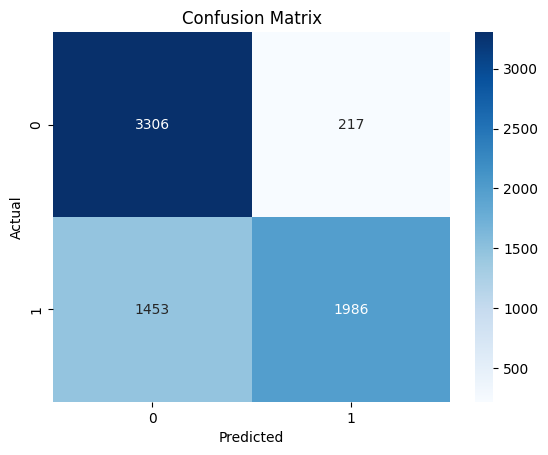

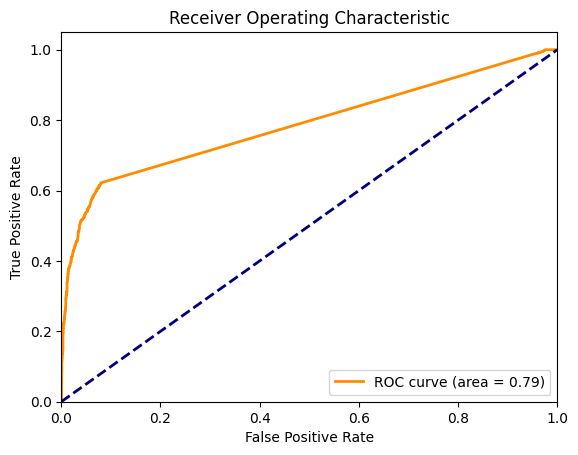

K-Nearest Neighbors:
Accuracy: 0.7292444699798908
Precision: 0.8912386706948641
Recall: 0.51468450130852
F1 Score: 0.6525345622119816


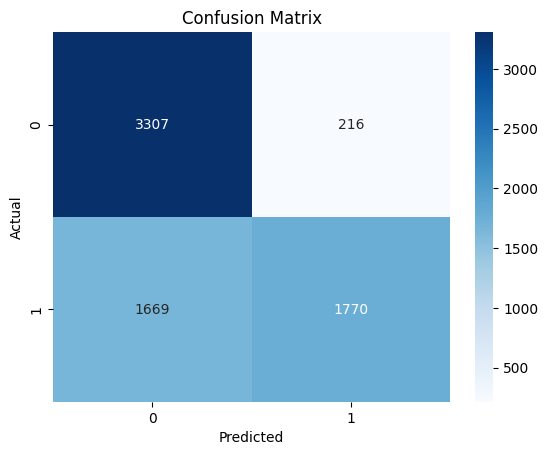

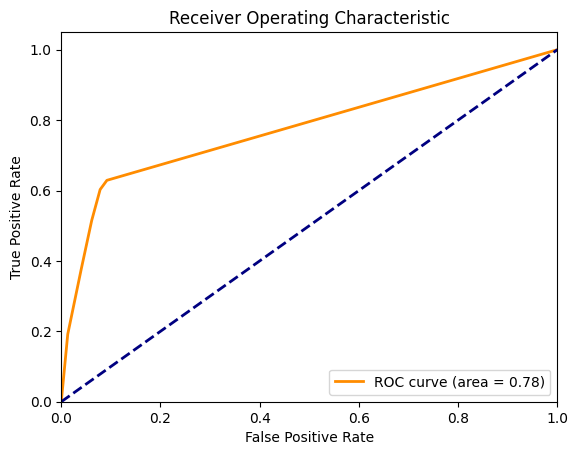

In [ ]:
X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, test_size=0.85, random_state=42)
X_test_sample, _, y_test_sample, _ = train_test_split(X_test, y_test, test_size=0.85, random_state=42)

print("Support Vector Machine:")
svm = SVC(kernel='linear', probability=True)
evaluate_model(svm, X_train_sample, y_train_sample, X_test_sample, y_test_sample)

print("K-Nearest Neighbors:")
knn = KNeighborsClassifier(n_neighbors=5, algorithm='brute')
evaluate_model(knn, X_train_sample, y_train_sample, X_test_sample, y_test_sample)

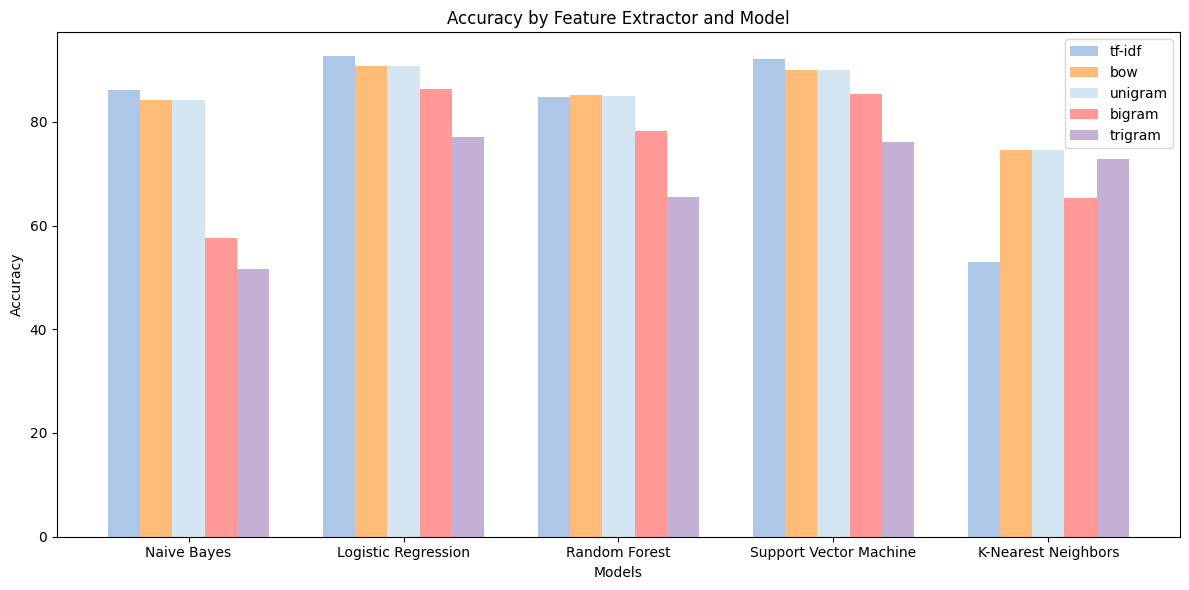

In [ ]:
feature_extractors = ['tf-idf', 'bow', 'unigram', 'bigram', 'trigram']
models = ['Naive Bayes', 'Logistic Regression', 'Random Forest', 'Support Vector Machine', 'K-Nearest Neighbors']

accuracies = {
    'tf-idf': [86.133, 92.62, 84.86, 92.11, 52.93],
    'bow': [84.12, 90.78, 85.14, 90.03, 74.59],
    'unigram': [84.12, 90.78, 84.98, 90.03, 74.59],
    'bigram': [57.57, 86.35, 78.14, 85.42, 65.39],
    'trigram': [51.70, 77.15, 65.44, 76.01, 72.92]
}

colors = ['#aec7e8', '#ffbb78', '#D4E6F1', '#ff9896', '#c5b0d5']

x = np.arange(len(models))
width = 0.15

fig, ax = plt.subplots(figsize=(12, 6))

for i, (extractor, acc) in enumerate(accuracies.items()):
    ax.bar(x + i * width, acc, width, label=extractor, color=colors[i])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by Feature Extractor and Model')
ax.set_xticks(x + width * (len(feature_extractors) - 1) / 2)
ax.set_xticklabels(models)
ax.legend()

fig.tight_layout()
plt.show()